In [1]:
# Автоматическая перезагрузка модулей при изменении
# Это позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2


In [2]:
# Импорт необходимых библиотек для анализа данных
import pandas as pd  # для работы с табличными данными
import numpy as np   # для математических операций
import random        # для работы с генератором случайных чисел

# Импорт пользовательских модулей с функциями для анализа
from helper import *  # вспомогательные функции для обработки данных
from plots import *   # функции для визуализации
from nlp import *     # функции для обработки естественного языка
import re


In [3]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости результатов
# Это критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random


## 1. Изучение структуры данных

**Цель:** Понять общую структуру датасета, количество записей, типы данных и качество информации.
Это первый и самый важный этап любого анализа данных - без понимания структуры невозможно корректно проводить дальнейшую обработку.


In [4]:
# Загружаем предобработанные данные из CSV файла
# Датасет содержит информацию о вакансиях с их описаниями и метками
df = pd.read_csv('data/train.csv')


In [5]:
# Выводим общую информацию о структуре датасета:
# - количество записей (1624)
# - количество столбцов (4)
# - типы данных в каждом столбце
# - количество пропущенных значений (в данном случае - отсутствуют)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


## 2. Проверка на корректность и качество данных

**Цель:** Выявить проблемы с данными, которые могут повлиять на качество анализа и моделирования.
Проверяем на дубликаты, пропущенные значения и аномальные записи.


### 2.1 Проверка на дубликаты

**Логика:** Дублированные записи могут искажать результаты анализа и обучения модели.
Если одна и та же вакансия встречается несколько раз, это может привести к переобучению.


In [6]:
# Подсчет числа полностью дублированных строк
# Результат: 0 означает, что дубликатов нет - это хорошо для качества данных
df.duplicated().sum()


np.int64(0)

### 2.2 Пропущенные значения

**Логика:** Пропущенные значения могут нарушить работу алгоритмов машинного обучения.
Нужно понять, есть ли пропуски и как они распределены по столбцам.


In [7]:
# Выводим число пропущенных значений по каждому столбцу
# Результат: все значения равны 0, что означает отсутствие пропусков - отличное качество данных
df.isnull().sum()


Class Index    0
Title          0
Description    0
dtype: int64

In [8]:
# Анализ описаний (менее 300 символов)
short_texts = df[df['Description'].str.len() < 300]
short_texts['Description'].value_counts()

Description
With the economy slowly turning up, upgrading hardware has been on businesses radar in the past 12 months as their number two priority.                                                                                                                15
Most IT Managers won #39;t question the importance of security, but this priority has been sliding between the third and fourth most important focus for companies.                                                                                    11
#NAME?                                                                                                                                                                                                                                                  9
This fourth priority #39;s main focus has been enterprise directories as organizations spawn projects around identity infrastructure.                                                                                                         

почти все тексты (112943 из 120000) короче 300 символов — это нормально для новостных описаний и не означает, что они неинформативны. Обнаружены дубликаты текстов и мусорные записи (например, #NAME?, HTML-артефакты вида #39;). Полное удаление всех коротких текстов приведёт к сильной потере данных и нецелесообразно. 

Что нужно сделать дальше:
Удалить явный мусор (пустые строки, #NAME?, битые записи).
Очистить HTML-артефакты и спецсимволы.
Отфильтровать только очень короткие тексты (например, < 100 символов), а не все < 300.

In [9]:
# Анализ коротких описаний (менее 100 символов)
short_texts = df[df['Description'].str.len() < 100]
short_texts['Description'].value_counts()

Description
#NAME?                                                                                                 9
The Associated Press By Ted Bridis                                                                     6
The software juggernaut that conquered the desktop is racing to get Windows into your next car.        6
The Associated Press By Rachel Konrad                                                                  3
The SX-8 is the latest incarnation of the high-end but relatively rare "vector" computer breed.        3
                                                                                                      ..
The annual Perseid meteor shower could provide a "spectacular" show, despite a disappointing start.    1
A rapid and accurate test for TB could cut infection rates around the world, say experts.              1
The first request by British scientists to clone human embryos has been granted by experts.            1
Heat waves in the 21st Century will be more

In [10]:
# Проверка сколько дублированных описанний
total_text = len(df)
unique_text = df['Description'].nunique()
duplicates = total_text - unique_text

total_text, unique_text, duplicates

(120000, 118723, 1277)

1277 дублированных текстов

In [11]:
# проверяем сколько одинаковых текстов с разными таргетами
dup = df.groupby('Description')['Class Index'].nunique()
conflicts = dup[dup > 1]
len(conflicts)

98

In [12]:
# Удаляем строки с описанием "Unknown" - это неинформативные записи
# Такие записи не несут смысловой нагрузки для классификации
df = df[df['Description'] != 'Unknown']


In [13]:
# Анализ длинных заголовков (более 100 символов)
# Слишком длинные заголовки могут содержать избыточную информацию или быть некорректными
long_titles = df[df['Title'].str.len() > 100]
long_titles['Title'].value_counts()


Title
Not All Jobs Belong To The White Man: Asian Minorities, Affirmative Action, And The Quest For Parity At Work           1
News: Droughts Like 1930s Dust Bowl May Have Been Unexceptional in Prehistoric Times, New Study Suggests               1
Attachmate Heightens Security, Centralises Management and Brings Microsoft Usability to Host Access with EXTRA! ...    1
 quot;Microsoft #39;s Actions Validate Our Linux Strategy Every Day, quot; Says &lt;b&gt;...&lt;/b&gt;                 1
Edward C. Baig: Personal Tech - Express takes digital music a step further, but it's no iPod (USATODAY.com)            1
In the  #39;Not For Long #39; league, the  #39;Skins #39; Joe Gibbs has missed an &lt;b&gt;...&lt;/b&gt;               1
Blessing or Curse? Top Newspaper Editors Examine Blogs' Role in the '60 Minutes' Uproar (Editor and Publisher)         1
Andrew Kantor: CyberSpeak - Linux takes a step (a small one) toward desktop acceptance (USATODAY.com)                  1
Digital music  #39;niche #

## 3. Детальное изучение признаков (и таргета)

**Цель:** Глубокий анализ каждого признака для понимания их информативности и распределения.
Это поможет выбрать правильные методы предобработки и понять, какие признаки наиболее важны для классификации.


In [14]:
# Создаем копию датасета для EDA, чтобы не изменять исходные данные
# Это позволяет безопасно экспериментировать с данными
df_EDA = df.copy()


### 3.1. Таргет (целевая переменная)

**Логика:** Анализ распределения целевой переменной критически важен для понимания задачи.
Нужно проверить баланс классов - если один класс сильно преобладает, это может потребовать специальных подходов.


In [15]:
# Анализируем распределение целевой переменной (Class Index)
#  1-World, 2-Sports, 3-Business, 4-Sci/Tech
# Смотрим, насколько сбалансированы классы
df_EDA['Class Index'].value_counts()


Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

### 3.2. Анализ заголовков (Title)

**Логика:** Заголовки вакансий часто содержат ключевую информацию о специальности.
Анализируем длину, частотность слов и их важность для классификации.


In [16]:
# Создаем признак длины заголовка в символах
# Длина текста может быть важным признаком для классификации
df_EDA['title_char_length'] = df_EDA['Title'].str.len()

In [17]:
# Статистическое описание длины заголовков
# Видим среднюю, минимальную, максимальную длину и квартили
df_EDA['title_char_length'].describe()


count    120000.000000
mean         42.071508
std          13.569405
min           6.000000
25%          33.000000
50%          41.000000
75%          49.000000
max         115.000000
Name: title_char_length, dtype: float64

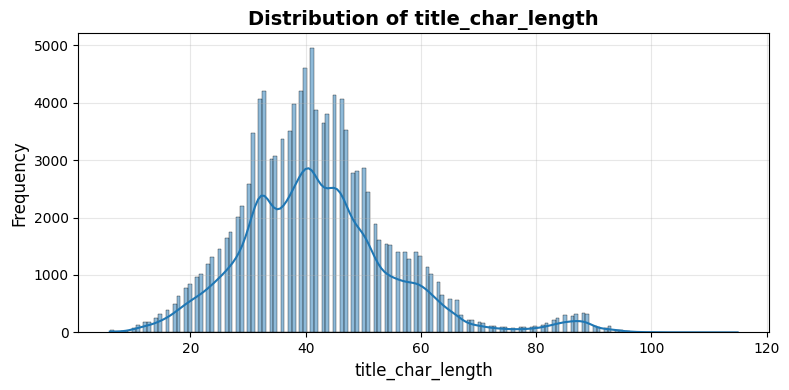

In [18]:
# Визуализируем распределение длины заголовков
# Гистограмма поможет понять, как распределена длина текстов
plot_hist_numeric(df_EDA, 'title_char_length')


In [19]:
def tokenize_words(text: str):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # убираем пунктуацию
    text = re.sub(r"\s+", " ", text).strip()
    return text.split()

In [20]:
# Токенизация заголовков
df_EDA['title_tokenized_words'] = df_EDA['Title'].apply(tokenize_words)

# Длина заголовка в словах
df_EDA['title_tokenized_words_len'] = df_EDA['title_tokenized_words'].apply(len)

In [21]:
# Подсчет частотности токенов в заголовках
# Удаляем стоп-слова и пунктуацию, приводим к нижнему регистру для корректного подсчета
# Это поможет выявить наиболее частые слова в заголовках
title_token_counts = token_counts(
    df_EDA, 
    'title_tokenized_words', 
    remove_stopwords=True, 
    remove_punctuation=True,
    lowercase_for_counting=True
)


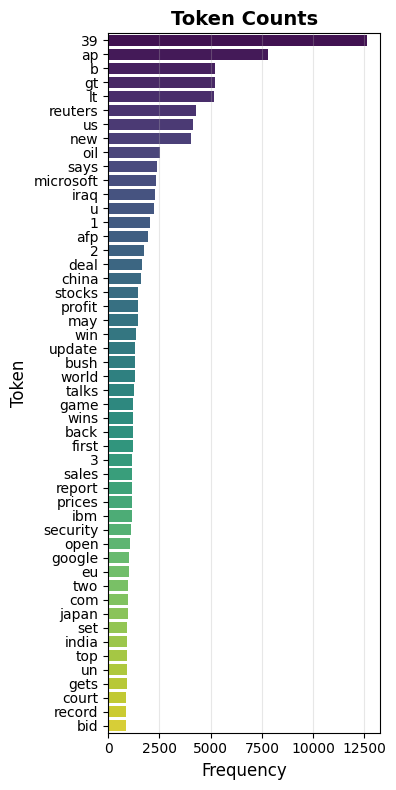

In [22]:
# Визуализация топ-50 самых частых токенов в заголовках
# Столбчатая диаграмма поможет быстро увидеть ключевые слова
barplot(
    title_token_counts, 
    title='Token Counts', 
    ylabel='Token', 
    top_n=50, 
    figsize=(4, 8)
)


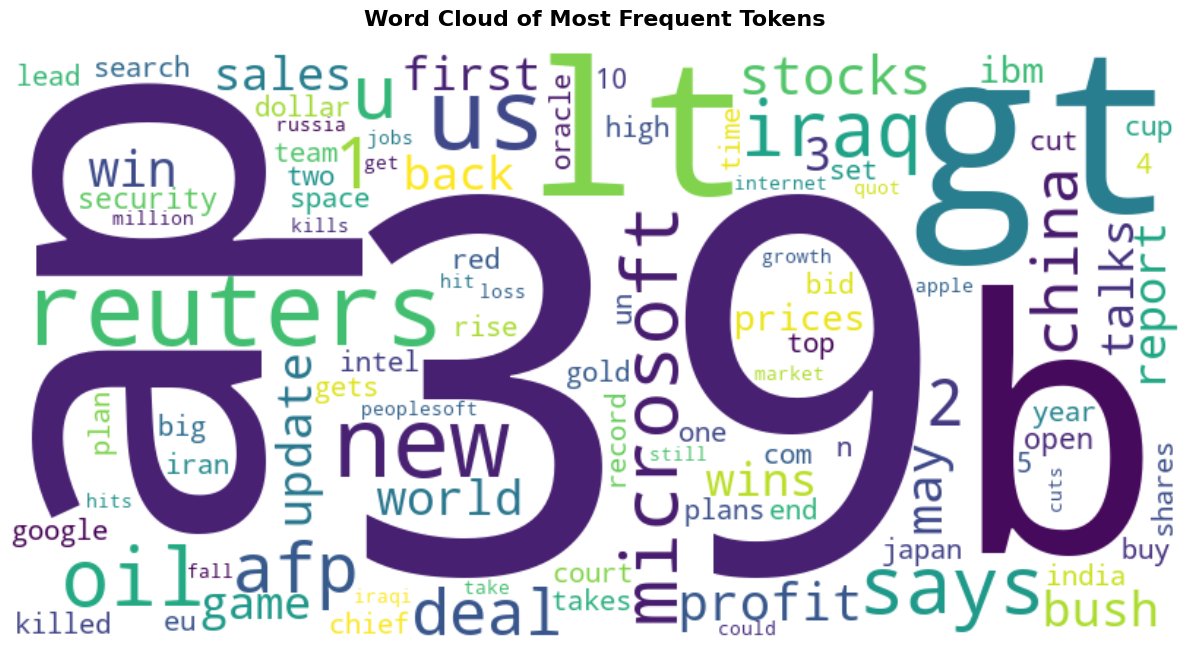

In [23]:
# Облако слов для визуализации частотности токенов
# Размер слова пропорционален его частотности - интуитивно понятная визуализация
plot_wordcloud(
    title_token_counts, 
    title='Word Cloud of Most Frequent Tokens', 
    max_words=100
)


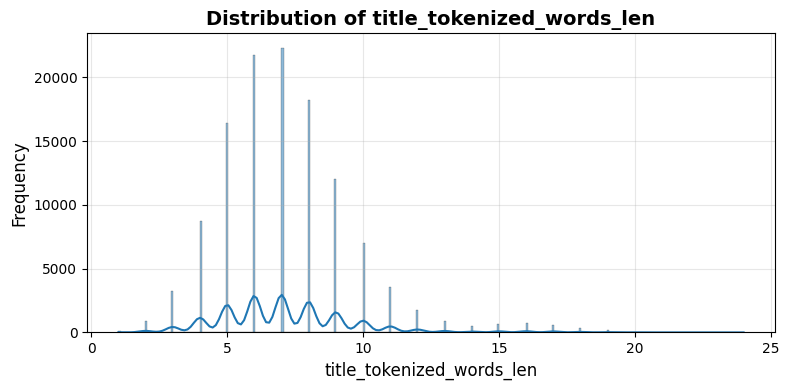

In [24]:
# Распределение количества токенов в заголовках
# Помогает понять, сколько слов в среднем содержит заголовок
plot_hist_numeric(df_EDA, 'title_tokenized_words_len')


In [25]:
# Очистка токенов: удаляем стоп-слова и знаки пунктуации
# Это подготовка для анализа важности токенов для классификации
df_EDA['title_tokenized_words_clean'] = df_EDA['title_tokenized_words'].apply(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    remove_punct_tokens=True,
    lowercase_for_counting=True
))


In [26]:
# Анализ важности токенов для классификации с помощью ANOVA F-test
# n=3: анализируем 1-граммы, 2-граммы и 3-граммы
# min_count=50: учитываем только токены, встречающиеся минимум 50 раз
# Это поможет выявить наиболее информативные для классификации слова и фразы
title_token_counts = count_based_analysis(
    texts_tokenized = df_EDA['title_tokenized_words_clean'], 
    labels = df_EDA['Class Index'], 
    n=3,
    metric='anova_f',
    min_count=50
)


In [27]:
# Выводим топ-5 наиболее важных для классификации токенов в заголовках
# Чем выше значение метрики, тем важнее токен для различения классов
title_token_counts.head(5)


,token,metric,count_1,freq_1,count_2,freq_2,count_3,freq_3,count_4,freq_4,total_count
0,iraq,2051.406399,2148,0.004546,9,0.000023,119,0.000269,20,0.000046,2296
1,oil,1867.742062,272,0.000576,8,0.000020,2218,0.005005,35,0.000081,2533
2,microsoft,1668.522318,11,0.000023,0,0.000000,328,0.000740,2009,0.004663,2348
3,profit,1137.305347,26,0.000055,5,0.000013,1305,0.002945,115,0.000267,1451
4,stocks,1017.596036,173,0.000366,1,0.000003,1267,0.002859,26,0.000060,1467


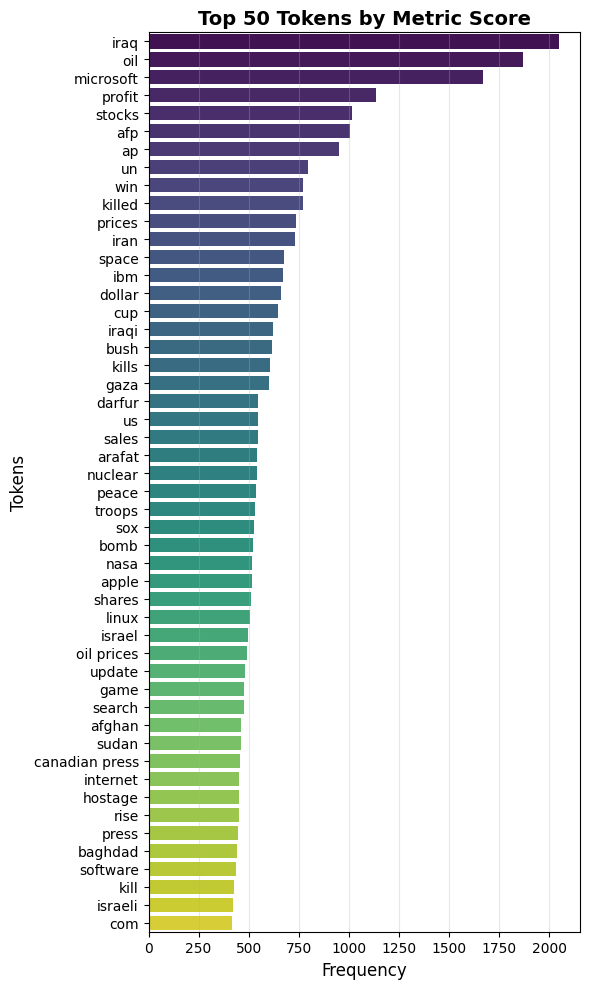

In [28]:
# Визуализация топ-50 токенов по важности для классификации
# Помогает понять, какие слова и фразы лучше всего различают DS и не-DS вакансии
barplot_data_metric = title_token_counts.set_index('token')['metric'].head(50)
barplot(barplot_data_metric, 'Top 50 Tokens by Metric Score', 'Tokens', figsize=(6, 10))


### 3.3. Анализ описаний (Description)

**Логика:** Описания вакансий содержат основную информацию о требованиях и обязанностях.
Это самый информативный признак для классификации, поэтому его анализ особенно важен.


In [29]:
# Анализ длины описаний в символах
# Описания обычно длиннее заголовков и содержат больше информации
df_EDA['description_char_length'] = df_EDA['Description'].str.len()


In [30]:
# Статистическое описание длины описаний
# Описания значительно длиннее заголовков, что ожидаемо
df_EDA['description_char_length'].describe()


count    120000.000000
mean        193.388517
std          64.472066
min           6.000000
25%         155.000000
50%         188.000000
75%         219.000000
max         985.000000
Name: description_char_length, dtype: float64

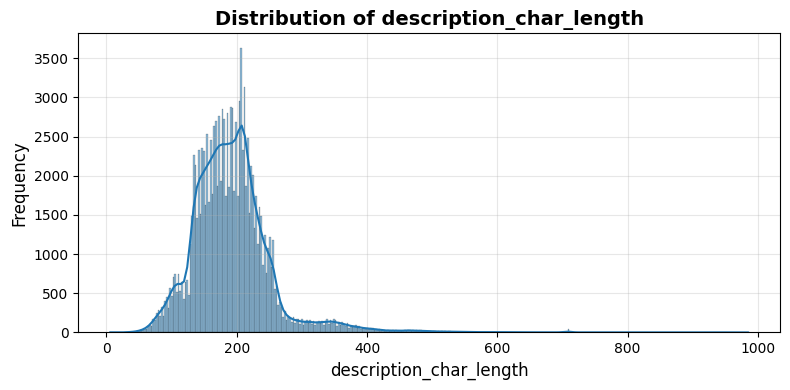

In [31]:
# Распределение длины описаний
# Видим, что большинство описаний довольно длинные (более 1000 символов)
plot_hist_numeric(df_EDA, 'description_char_length')


In [32]:
# Токенизация описаний
# Описания содержат больше токенов, чем заголовки
df_EDA['description_tokenized_words'] = df_EDA['Description'].apply(tokenize_words)
df_EDA['description_tokenized_words_len'] = df_EDA['description_tokenized_words'].apply(len)


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


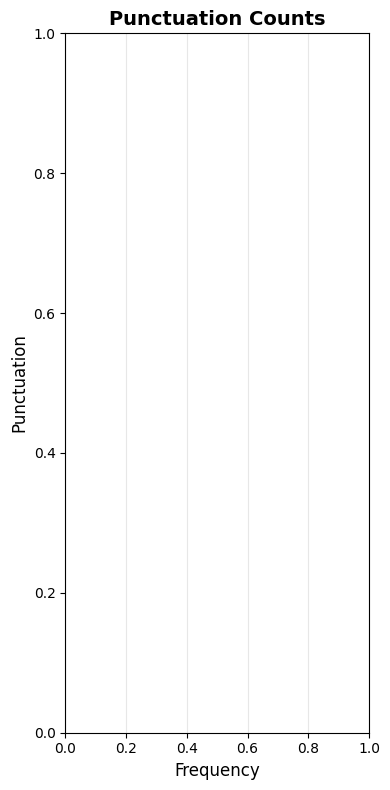

In [33]:
# Анализ знаков пунктуации в описаниях
# Многие описания в markdown формате, поэтому знаки пунктуации могут быть информативными
punct_counts = punctuation_counts(df_EDA, 'description_tokenized_words')
barplot(punct_counts, title='Punctuation Counts', ylabel='Punctuation', top_n=25, figsize=(4, 8))


пунктуации нет тк word-tokenization её уже выкинул

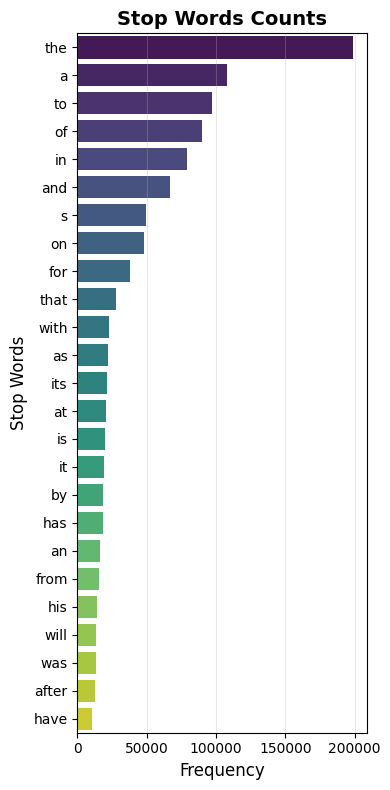

In [34]:
# Анализ стоп-слов в описаниях
# Стоп-слова (артикли, предлоги, союзы) обычно удаляются при обработке текста
stop_words_counts = stopwords_count(df_EDA, 'description_tokenized_words')
barplot(stop_words_counts, title='Stop Words Counts', ylabel='Stop Words', top_n=25, figsize=(4, 8))


In [35]:
# Подсчет частотности токенов в описаниях (без стоп-слов и пунктуации)
# Это поможет выявить ключевые технические термины и навыки
token_counts = token_counts(
    df_EDA, 
    'description_tokenized_words', 
    remove_stopwords=True, 
    remove_punctuation=True,
    lowercase_for_counting=True
)


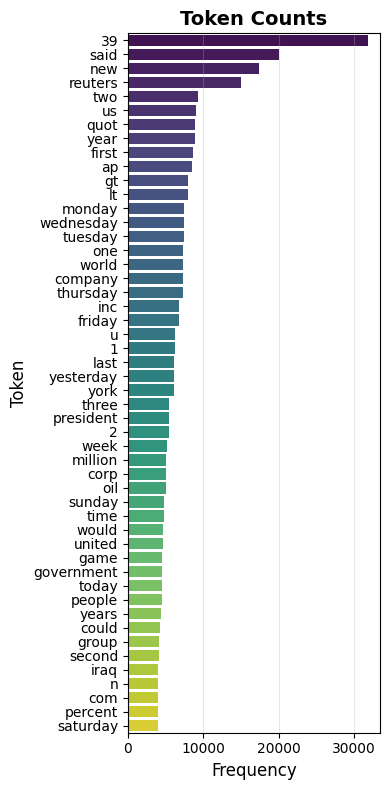

In [36]:
# Топ-50 самых частых токенов в описаниях
# Видим технические термины, языки программирования, инструменты
barplot(token_counts, title='Token Counts', ylabel='Token', top_n=50, figsize=(4, 8))


Самый частый токен это 39 —  мусорный артефакт HTML-кодирования, его нужно удалить на этапе очистки.

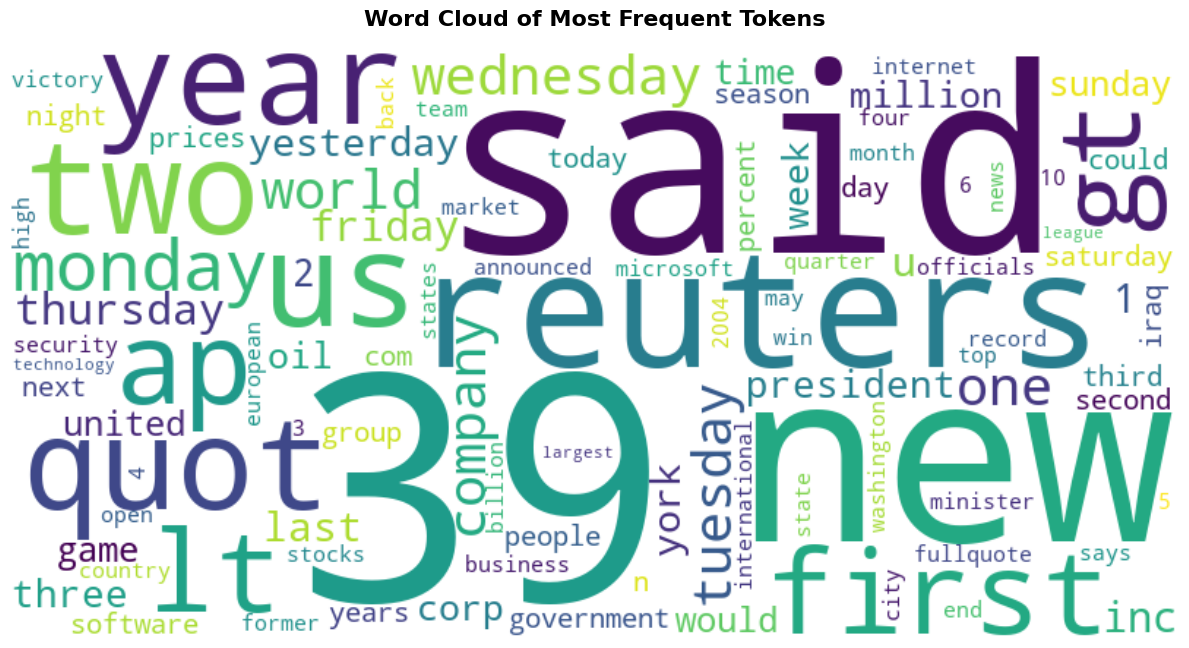

In [37]:
# Облако слов для описаний
# Визуально показывает, какие технологии и навыки чаще всего упоминаются
plot_wordcloud(token_counts, title='Word Cloud of Most Frequent Tokens', max_words=100)


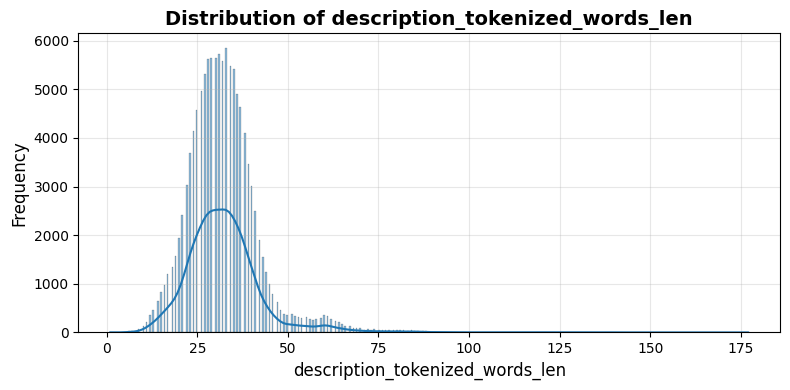

In [38]:
# Распределение количества токенов в описаниях
# Описания содержат значительно больше токенов, чем заголовки
plot_hist_numeric(df_EDA, 'description_tokenized_words_len')


In [39]:
# Очистка токенов описаний: удаляем стоп-слова и пунктуацию
# Подготавливаем данные для анализа важности токенов
df_EDA['description_tokenized_words_clean'] = df_EDA['description_tokenized_words'].apply(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    remove_punct_tokens=True,
    lowercase_for_counting=True
))


In [40]:
# Анализ важности токенов в описаниях для классификации
# Это самый важный анализ - выявляем, какие слова и фразы лучше всего различают категории 
# n=3: анализируем 1-граммы, 2-граммы и 3-граммы
counts = count_based_analysis(
    texts_tokenized = df_EDA['description_tokenized_words_clean'], 
    labels = df_EDA['Class Index'], 
    n=2,
    metric='anova_f',
    min_count=100
)


In [41]:
# Настраиваем отображение чисел с плавающей точкой для лучшей читаемости
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [42]:
# Выводим результаты анализа важности токенов
# Чем выше значение метрики, тем важнее токен для классификации DS vs не-DS вакансий
counts


,token,metric,count_1,freq_1,count_2,freq_2,count_3,freq_3,count_4,freq_4,total_count
0,iraq,2997.76992,3689,0.00299,23,0.00002,270,0.00020,57,0.00005,4039
1,minister,2602.22496,3095,0.00251,31,0.00003,233,0.00018,65,0.00005,3424
2,prices,2498.77379,271,0.00022,7,0.00001,3250,0.00246,215,0.00017,3743
3,inc,2441.30642,69,0.00006,10,0.00001,4379,0.00332,2339,0.00190,6797
4,oil,2412.91484,747,0.00061,14,0.00001,4168,0.00316,102,0.00008,5031
...,...,...,...,...,...,...,...,...,...,...,...
5081,asking,0.32867,35,0.00003,33,0.00003,28,0.00002,35,0.00003,131
5082,next week,0.28513,144,0.00012,131,0.00011,132,0.00010,132,0.00011,539
5083,concerned,0.27925,39,0.00003,38,0.00003,32,0.00002,38,0.00003,147
5084,longtime,0.22241,27,0.00002,26,0.00002,27,0.00002,22,0.00002,102


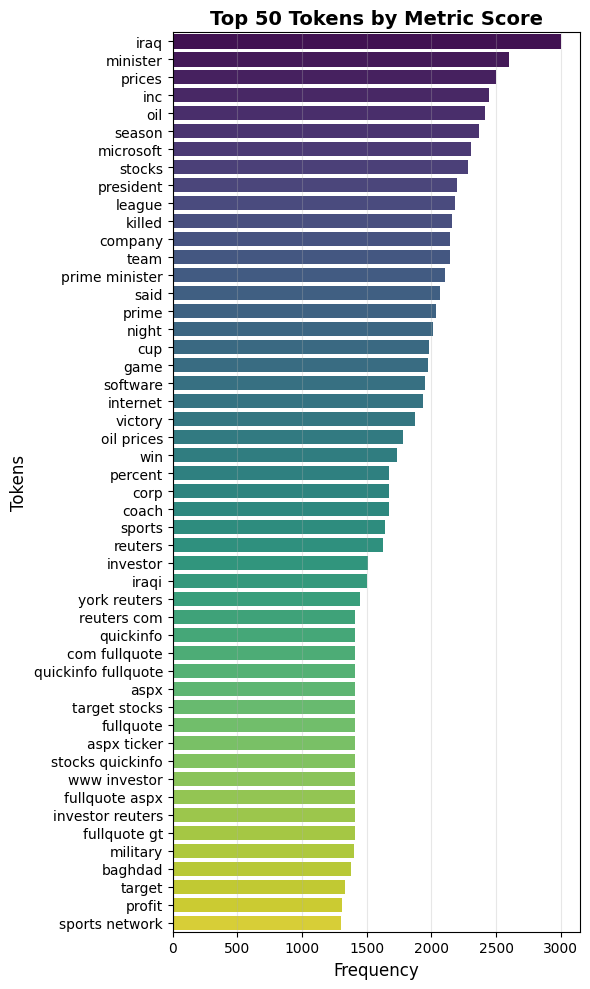

In [43]:
# Визуализация топ-50 наиболее важных для классификации токенов в описаниях
# Это ключевой результат EDA - показывает, какие термины лучше всего различают типы вакансий
barplot_data_metric = counts.set_index('token')['metric'].head(50)
barplot(barplot_data_metric, 'Top 50 Tokens by Metric Score', 'Tokens', figsize=(6, 10))
